# Assignment

# Supervised Learning

Work assembled by Alejandro Gonçalves, Pedro Fernandes, Francisca Mihalache.

## Table of Contents

1. [Introduction](#introduction)

2. [Chosen Algorithm](#chosen-algorithm)

3. [Metrics](#metrics)
            
4. [Distances](#distances)
   - 4.1. [Euclidian Distance](#euclidian-distance)
   - 4.2. [L2 Distance](#l2-distance)
   - 4.3. [Euclidian Distance (features)](#euclidian-distance-features)
   - 4.4. [Cosine Similarity](#cosine-similarity)
   - 4.5. [Manhattan Distance](#manhattan-distance)
   - 4.6. [Jaccard Distance](#jaccard-distance)
   - 4.7. [Mahalanobis Distace](#mahalanobis-distance)
5. [Base](#base)

6. [Improved Algorithm](#improved-algorithm)
   - 6.1. [Bagging](#Bagging)
   - 6.2. [KNN-Features](#knn-features)
7. [Training](#training)
   - 7.1. [Base Training](#base-training)
   - 7.2. [Bagging Training](#bagging-training)
   - 7.3. [Features Training](#features-training)

8. [Comparisons](#comparisons) 
   - 8.1. [Find k knn](#optimal-number-of-neighborsk)
   - 8.2. [Find k Knn comparison](#comparisons-between-models)

9. [Statistics](#statistics)
   - 9.1 [Confusion Matrix](#confusion-matrix)
   - 9.2 [PCA](#pca)
   - 9.3 [ROC curve](#roc-curve)
   - 9.4 [Statistical Performance](#statistical-performance)

10. [Dataset tests](#dataset-tests)


## Introduction

In this assignment we'll dive into a selected Machine Learning (ML) algorithm, understanding its theory and testing its performance. We'll explore benchmarking methodologies and differentiate between ML research and practical application, ensuring a balanced understanding of theory and practice in ML.

### Imports
To begin with, we need to import some modules.

In [1]:
import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn import preprocessing
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV, 
                                     RandomizedSearchCV, cross_validate, LeaveOneOut)
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, r2_score,
                             f1_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc)
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.utils import resample

import openml as oml

from pandas.api.types import is_numeric_dtype

from collections import Counter


### Reading and cleaning the dataset

In [3]:
df1 = pd.read_csv('csvs\\breast.csv')
df1.head(5)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/qx/kgqzhwb50b7flqgr05m062t40000gn/T/ipykernel_18469/1163963628.py", line 1, in <module>
    df1 = pd.read_csv('csvs\\breast.csv')
  File "/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/pandas/io/parsers/readers.py", line 912, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/pandas/io/parsers/readers.py", line 577, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/pandas/io/parsers/readers.py", line 1407, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/Users/franciscamihalache/Library/Python/3.9/lib/python/site-packages/pan

In [ ]:
# If exists any missing values
print(df1.isnull().sum())

id                       0
Clump_Thickness          0
Cell_Size_Uniformity     0
Cell_Shape_Uniformity    0
Marginal_Adhesion        0
Single_Epi_Cell_Size     0
Bare_Nuclei              0
Bland_Chromatin          0
Normal_Nucleoli          0
Mitoses                  0
Class                    0
dtype: int64


In [ ]:
# Replacing benign with 0 and malignant with 1 to be easier to understand and removing the lines that "?" is present. 
df1['Class'] = df1['Class'].replace({'benign': 0, 'malignant': 1})
df1['Bare_Nuclei'].replace('?', np.nan, inplace=True)
df1['Bare_Nuclei'] = pd.to_numeric(df1['Bare_Nuclei'], errors='coerce')
df1.dropna(subset=['Bare_Nuclei'], inplace=True)
df1.head()

C:\Users\aleja\AppData\Local\Temp\ipykernel_1588\727482383.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Class'] = df1['Class'].replace({'benign': 0, 'malignant': 1})
C:\Users\aleja\AppData\Local\Temp\ipykernel_1588\727482383.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Bare_N

,id,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1,5,1,1,1,2,1.0,3,1,1,0
1,2,5,4,4,5,7,10.0,3,2,1,0
2,3,3,1,1,1,2,2.0,3,1,1,0
3,4,6,8,8,1,3,4.0,3,7,1,0
4,5,4,1,1,3,2,1.0,3,1,1,0


In [ ]:
df1.describe()

,id,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,352.355783,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,202.563927,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,177.500000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,356.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,527.500000,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,699.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [ ]:
cols1 = ['Clump_Thickness','Cell_Size_Uniformity']
X1 = df1[cols1]
y1 = df1['Class']

<Axes: xlabel='Clump_Thickness', ylabel='Cell_Size_Uniformity'>

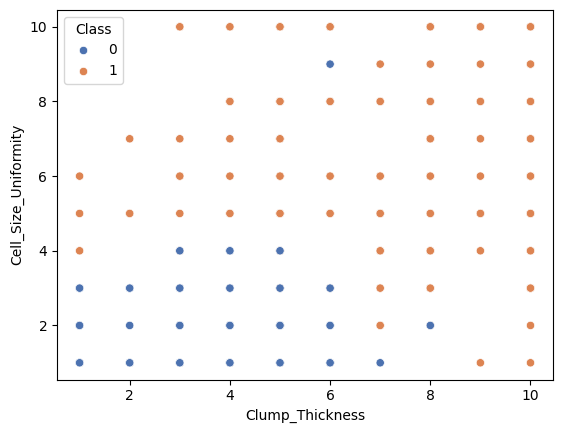

In [ ]:
sns.scatterplot(x = X1['Clump_Thickness'], y = X1['Cell_Size_Uniformity'], hue = y1, palette = "deep")

## Chosen Algorithm

For this assignment, we decided to use KNN. [[more about K-Nearest Neighbors]](#knnk-nearest-neighbors)

In our initial approach, we will implement the algorithm without modifications and analyze the outcomes. Sencondly, we aim to enhance these results by implementing a modified algorithm for comparison. We will adjust the number of k-neighbors, explore different distance methods, and experiment with various features to achieve this improvement.

[[go back to the top]](#table-of-contents)

## Metrics
[[go back to the topic]](#chosen-algorithm)

The metrics.py file contains various performance evaluation functions

In [ ]:
# coding:utf-8

EPS = 1e-15


def unhot(function):
    """Convert one-hot representation into one column."""

    def wrapper(actual, predicted):
        if len(actual.shape) > 1 and actual.shape[1] > 1:
            actual = actual.argmax(axis=1)
        if len(predicted.shape) > 1 and predicted.shape[1] > 1:
            predicted = predicted.argmax(axis=1)
        return function(actual, predicted)

    return wrapper


def absolute_error(actual, predicted):
    return np.abs(actual - predicted)


@unhot
def classification_error(actual, predicted):
    return (actual != predicted).sum() / float(actual.shape[0])


@unhot
def accuracy(actual, predicted):
    return 1.0 - classification_error(actual, predicted)


def mean_absolute_error(actual, predicted):
    return np.mean(absolute_error(actual, predicted))


def squared_error(actual, predicted):
    return (actual - predicted) ** 2


def squared_log_error(actual, predicted):
    return (np.log(np.array(actual) + 1) - np.log(np.array(predicted) + 1)) ** 2


def mean_squared_log_error(actual, predicted):
    return np.mean(squared_log_error(actual, predicted))


def mean_squared_error(actual, predicted):
    return np.mean(squared_error(actual, predicted))


def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


def root_mean_squared_log_error(actual, predicted):
    return np.sqrt(mean_squared_log_error(actual, predicted))


def logloss(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss / float(actual.shape[0])


def hinge(actual, predicted):
    return np.mean(np.max(1.0 - actual * predicted, 0.0))


def binary_crossentropy(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    return np.mean(-np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted)))


# aliases
mse = mean_squared_error
rmse = root_mean_squared_error
mae = mean_absolute_error


def get_metric(name):
    """Return metric function by name"""
    try:
        return globals()[name]
    except Exception:
        raise ValueError("Invalid metric function.")

## Distances
[[go back to the topic]](#chosen-algorithm)

The inicial github file provides these functions: 

- the Euclidean distance 

- the L2 distance matrix for a set of points in a dataset.
  
But, as said above, we'll explore different distance methods, like:
- Euclidean distance (features)
- Cosine Similarity
- Manhattan Distance
- Jaccard Distance
- Mahalanobis distance


### Euclidian Distance
[[go back to the topic]](#distances)

This function is designed to calculate the distance between two individual points p1 and p2.
Calculates the straight-line distance between two points in Euclidean space, denoted as p1 and p2.

In [ ]:
# coding:utf-8
def euclidean_distance(a, b):
    if isinstance(a, list) and isinstance(b, list):
        a = np.array(a)
        b = np.array(b)

    return math.sqrt(sum((a - b) ** 2))


### L2 Distance
[[go back to the topic]](#distances)


The function l2_distance(X) calculates the pairwise L2 or Euclidean distances between rows of a matrix X. This matrix X is expected to be a two-dimensional NumPy array where each row represents a point in a multidimensional space. 

In [ ]:
def l2_distance(X):
    sum_X = np.sum(X * X, axis=1)
    return (-2 * np.dot(X, X.T) + sum_X).T + sum_X

### Euclidian Distance (features)
[[go back to the topic]](#distances)

This function is designed to calculate the Euclidean distances between a single point p1 and multiple points p2.

In [ ]:
def euclidean_distance_features(p1, p2):
    temp = p1 - p2[:, np.newaxis]
    euclid_dist = np.sqrt(np.sum(temp ** 2, axis=-1))
    return euclid_dist

### Cosine Similarity
[[go back to the topic]](#distances)

The function cosine_similarity(row1, row2) calculates the cosine similarity between two vectors represented by row1 and row2. Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space, providing an indication of how similar the vectors are in terms of orientation, regardless of their magnitude.


In [ ]:
def cosine_similarity(row1, row2):
    norm1 = norm(row1)
    norm2 = norm(row2)
    if norm1 == 0 or norm2 == 0:
        return 0  # avoid zero division
    simi = np.dot(row1, row2) / (norm1 * norm2)
    return simi

### Manhattan Distance
[[go back to the topic]](#distances)

The function calculates the distance between two vectors a and b.


In [ ]:
def manhattan_distance(a,b):
    return sum(abs(val1-val2) for val1,val2 in zip(a,b))

### Jaccard Distance
[[go back to the topic]](#distances)

The function computes the Jaccard distance between two lists, which represent sets of elements. The Jaccard distance is a measure of dissimilarity between two sets based on the size of their intersection divided by the size of their union.


In [ ]:
def jaccard_distance(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1)+len(list2))-intersection
    return float(intersection)/union

### Mahalanobis distance
[[go back to the topic]](#distances)

This function computes the Mahalanobis distance that measures the distance between a point and a distribution, considering both the variance and covariance of the distribution.


In [2]:
import numpy as np
def mahalanobis_distance(x, data):
    mean = np.mean(data, axis=0)
    covariance_matrix = np.cov(data, rowvar=False)
    try:
        inv_covmat = np.linalg.inv(covariance_matrix)
    except np.linalg.LinAlgError:
        epsilon = 1e-5
        inv_covmat = np.linalg.inv(covariance_matrix + epsilon * np.eye(data.shape[1]))
    diff = x - mean

    mahalanobis_dist = np.sqrt(np.dot(np.dot(diff.T, inv_covmat), diff))
    return mahalanobis_dist

#exemplo de teste 
# Gerar alguns dados aleatórios para teste
np.random.seed(42)
data = np.random.randn(100, 2) 
x = np.array([0, 0]) 

# Calcular a distância de Mahalanobis
distance = mahalanobis_distance(x, data)
print("Distância de Mahalanobis:", distance)

Distância de Mahalanobis: 0.1403242710668961


## Base
[[go back to the top]](#table-of-contents)

Here, we present the implementation of the original algorithm without any modifications.

This BaseEstimator python script is used for creating estimators. Includes methods for configuring input data, helping models, and making predictions.

In [ ]:
# coding:utf-8
import numpy as np


class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

### Original KNN
[[go back to the topic]](#base)

This Python code defines a base framework and specific implementations for the k-nearest neighbors (KNN) algorithm, with a classifier.


In [ ]:
# coding:utf-8

class KNNBase(BaseEstimator):
    def __init__(self, k=7, distance_func=euclidean_distance):
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
        """

        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]

        return np.array(predictions)

    def _predict_x(self, x):
        """Predict the label of a single instance x."""

        # compute distances between x and all examples in the training set.
        distances = (self.distance_func(x, example) for example in self.X )

        # Sort all examples by their distance to x and keep their target value.
        neighbors = sorted(((dist, target) for (dist, target) in zip(distances, self.y)), key=lambda x: x[0])

        # Get targets of the k-nn and aggregate them (most common one or
        # average).
        neighbors_targets = [target for (_, target) in neighbors[: self.k]]

        return self.aggregate(neighbors_targets)


class KNNClassifier(KNNBase):
    """Nearest neighbors classifier.

    Note: if there is a tie for the most common label among the neighbors, then
    the predicted label is arbitrary."""

    def aggregate(self, neighbors_targets):
        """Return the most common target label."""

        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

### Implementation

This Python script defines and executes a classification task using a k-nearest neighbors (KNN) algorithm from a synthetic dataset.

[[bo back to the topic]](#base)


In [ ]:
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

def classification():
    X, y = make_classification(
        n_samples=500,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        random_state=1111,
        class_sep=1.5,
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1111)

    clf = KNNClassifier(k=7, distance_func=euclidean_distance)

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print("classification accuracy", accuracy(y_test, predictions))
    #print(classification_report(y_test, predictions))



if __name__ == "__main__":
    classification()

classification accuracy 0.96


## Improved Algorithm
[[go back to the top]](#table-of-contents)

In this chapter we will approach bagging [[more about bagging]](#bagging)

In machine learning, blending different methods often boosts resilience. By merging KNN Bagging and KNN Features, we harness ensemble learning and feature customization for more robust models.

### Bagging 
[[go back to the topic]](#improved-algorithm)

**Bagging**, short for Bootstrap Aggregating is an ensemble technique that improves model stability and accuracy by training multiple models on different subsets of data and combining their predictions. This method reduces variance, enhances performance, and minimizes overfitting.


The `KNNBagging` class integrates the principles of bagging with the k-Nearest Neighbors (k-NN) algorithm. By allowing the selection of various distance metrics, it enhances the adaptability and precision of the k-NN method:

After calculating distances using various metrics, the k nearest neighbors are identified for each test instance and the most common label among them are selected. This technique aggregates outcomes from different sub-models, effectively reducing prediction variance and improving accuracy.

In [ ]:
#classe que eu acho que esta funcional 
class KNN_Bagging:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _get_distances(self, x, distance_func):
        return [distance_func(x, x_train) for x_train in self.X_train]

    def _get_labels(self, distances):
        k_indices = np.argsort(distances)[:self.k]
        return [self.y_train[idx] for idx in k_indices]

    def _most_frequent_label(self, labels):
        unique_classes, counts = np.unique(labels, return_counts=True)
        return unique_classes[np.argmax(counts)]

    def predict(self, X, metric_index):
        distance_functions = [euclidean_distance, cosine_similarity, manhattan_distance, jaccard_distance]
        predictions = []

        for x in X:
            distances = self._get_distances(x, distance_functions[metric_index])
            labels = self._get_labels(distances)
            predictions.append(self._most_frequent_label(labels))

        return predictions
    
    def predict_probabilities(self, X):
        y_proba = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            sorted_indices = np.argsort(distances)[:self.k]
            labels = self.y_train[sorted_indices]
            unique_classes, counts = np.unique(labels, return_counts=True)
            class_frequencies = counts / self.k
            y_proba.append(class_frequencies)

        return np.array(y_proba)

### KNN-Features
[[go back to the topic]](#improved-algorithm)

The `KNN_Features` class optimizes the k-Nearest Neighbors algorithm by prioritizing influential features in determining data point proximity. It calculates distances with a chosen metric, identifies the k nearest neighbors, and selects the most prevalent label among them, boosting prediction accuracy. Furthermore, it estimates class probabilities based on nearest neighbor label frequencies, offering a quantifiable prediction confidence measure.

In [ ]:
class KNN_Features:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        return  [self._predict(x) for x in X]
    
    def _predict(self, x):
        distances = [euclidean_distance_features(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        most_frequent_label = np.bincount(k_nearest_labels).argmax()
        return most_frequent_label

    def predict_probabilities(self, X):
        y_proba = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_classes = self.y_train[k_indices]
            class_frequencies = np.bincount(k_nearest_classes, minlength=len(np.unique(self.y_train))) / self.k
            y_proba.append(class_frequencies)
        return np.array(y_proba)

In [ ]:
import numpy as np

class KNN_Features:
    def __init__(self, num_neighbors):
        self.num_neighbors = num_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def single_prediction(self, test_instance):
        distances = np.sqrt(((self.features_train - test_instance) ** 2).sum(axis=1))
        nearest_neighbors_indices = np.argsort(distances)[:self.num_neighbors]
        nearest_labels = self.labels_train[nearest_neighbors_indices]
        return np.bincount(nearest_labels).argmax()

    def predict(self, features_test):
        return np.array([self.single_prediction(x) for x in features_test])

    def predict_probabilities(self, features_test):
        probabilities = []
        for x in features_test:
            distances = np.sqrt(((self.features_train - x) ** 2).sum(axis=1))
            nearest_neighbors_indices = np.argsort(distances)[:self.num_neighbors]
            nearest_labels = self.labels_train[nearest_neighbors_indices]
            label_freq = np.bincount(nearest_labels, minlength=len(np.unique(self.labels_train))) / self.num_neighbors
            probabilities.append(label_freq)
        return np.array(probabilities)


## Training

Training is a critical process in machine learning where a model learns from a dataset to identify patterns and make informed decisions. This process is essential as it equips the model to accurately predict outcomes on new, unseen data.

We will implement three distinct training approaches to optimize our model's performance:


### Base training
[[go back to the topic]](#chosen-algorithm)

Tests on the Original k-NN Implementation: 

In [ ]:
def train_Base(dataset, k, test_size):
    random_state = 1234
    X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    df = pd.DataFrame(X, columns=attribute_names)
    numeric_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
    X = df[numeric_cols].values
    Y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    clf = KNNClassifier(k=k)  # Assume KNNClassifier já está definido
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy, y_test, predictions, X_test, clf, X, Y, y_train

### Bagging Training
[[go back to the topic]](#improved-algorithm)

This function employs a KNN_Bagging classifier trained on various distance metrics (Euclidean, Cosine, Manhattan, Jaccard, and Mahalanobis). For each metric, it generates predictions and aggregates the most common results across all metrics to enhance prediction robustness. 



In [ ]:
def train_bagging(dataset, k, test_size):
    random_state = 1234
    X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    df = pd.DataFrame(X, columns=attribute_names)
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    X_numeric = df[numeric_cols].values
    y_array = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X_numeric, y_array, test_size=test_size, random_state=random_state)
    clf = KNN_Bagging(k)  
    clf.fit(X_train, y_train)
    predictions_general = []
    for idx in range(5): 
        predictions = clf.predict(X_test, idx)
        most_common = Counter(predictions).most_common(1)[0][0]
        predictions_general.append(most_common)
    accuracy = accuracy_score(y_test, predictions_general)
    return accuracy, y_test, predictions_general, X_test, clf, X, y, y_train

#### k-NN Feature Ensemble
This function constructs an ensemble of k-Nearest Neighbors (k-NN) classifiers, each trained on a **randomly selected subset of features from the data**. This approach diversifies the training process by using different feature combinations for each classifier, enhancing accuracy of the ensemble. The classifiers are then compiled, and the most effective one, determined by frequency of selection, is chosen to represent the ensemble. 

In [ ]:
#MUDAR ESTA FUNCAOOOO
def knn_ensemble(X, y, n_neighbors, n_classifiers, sample_size):
    
    #subconjuntos de features aleatórias para cada classificador
    n_samples, n_features = X.shape
    feature_subsets = [np.random.choice(range(n_features), int(sample_size * n_features), replace=False) for _ in range(n_classifiers)]
    classifiers = []

    # creat a trainning sample with resampling
    for features in feature_subsets:
        X_subset = X[:, features]
        X_resampled, y_resampled = resample(X_subset, y, n_samples=int(sample_size * n_samples), replace=True, random_state=42)
        cls = KNN_Features(5)
        cls.fit(X_resampled, y_resampled)
        classifiers.append(cls)
    
    #Ensemble of classifiers
    ensemble = Counter(classifiers).most_common(1)[0][0]
    
    return ensemble,cls

### Features Training 

Train an ensemble of k-NN models using `knn_ensemble` on the training set, where each model employs a unique feature subset to enhance generalization and reduce overfitting. Then, use this ensemble to predict outcomes on the test set and assess its performance by calculating accuracy in capturing dataset patterns.



In [ ]:
def train_features(dataset, k, test_size):
    random_state = 1234
    X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
    df = pd.DataFrame(X, columns=attribute_names)
    numeric_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
    X = df[numeric_cols].values
    Y = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    ensemble, clf = knn_ensemble(X, y, k, 5, 0.8)
    predictions = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy,y_test,predictions,X_test,clf,X,Y,y_train


## Optimal number of Neighbors(K)

To achieve reliable predictions and avoid overfitting and underfitting it´s important to find the best K neighbors for a certain dataset. 

In [ ]:
def find_k_knn(X,y,algorithm,kmax=10):
    k_values = [i for i in range (1,kmax+1)]
    accuracies = list()
    for k in k_values:
        if algorithm == 1:
            knn = KNNClassifier(k)
            accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_Base(dataset,k)
        elif algorithm == 2:
            knn = KNN_Bagging(k)
            accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_bagging(dataset,k)
        else:
            knn = KNN_Features(k)
            accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_features(dataset,k)
        accuracies.append(accuracy)

    #Ploting the results of Cross Validation
    sns.lineplot(x = k_values, y = accuracies, marker = 'o')
    plt.xlabel("K Values")
    plt.ylabel("Accuracy Score of k-NN")
    plt.title('Estimates by Cross Validation')
    
    best_index = np.argmax(accuracies)    
    best_k = k_values[best_index]    
    print(f'Best k = {best_k}')

### Comparisons (between models)

The performance of different k-NN models is compared by evaluating their accuracy scores across various values of k. It plots the results of cross-validation and identifies the best k value for each model.

In [ ]:
def find_k_knn_comparison(X,y,kmax=10):
    k_values = [i for i in range (1,kmax+1)]
    accuracies_base = list()
    accuracies_bagging = list()
    accuracies_features = list()
    for k in k_values:
        knn_base = KNNBase(k)
        knn_bagging = KNN_Bagging(k)
        knn_features = KNN_Features(k)
        
        accuracy_base,y_test,predictions,X_test,clf,X,Y,y_train = train_Base(dataset,k)
        accuracy_bagging,y_test,predictions,X_test,clf,X,Y,y_train = train_bagging(dataset,k)
        accuracy_features,y_test,predictons,X_test,clf,X,Y,y_train = train_features(dataset,k)
        
        accuracies_base.append(accuracy_base)
        accuracies_bagging.append(accuracy_bagging)
        accuracies_features.append(accuracy_features)

    #Ploting the results of Cross Validation
    sns.lineplot(x = k_values, y = accuracies_base, marker = 'o')
    sns.lineplot(x = k_values, y = accuracies_bagging, marker = 'o')
    sns.lineplot(x = k_values, y = accuracies_features, marker = 'o')
    plt.xlabel("K Values")
    plt.ylabel("Accuracy Score of k-NN")
    plt.title('Estimates by Cross Validation')
    
    best_index_base = np.argmax(accuracies_base)    
    best_k_base = k_values[best_index_base] 
    best_index_bagging = np.argmax(accuracies_bagging)    
    best_k_bagging = k_values[best_index_bagging] 
    best_index_features = np.argmax(accuracies_features)    
    best_k_features = k_values[best_index_features] 
    print(f'Best k algorithm Base = {best_k_base}')
    print(f'Best k Bagging = {best_k_bagging}')
    print(f'Best k Features = {best_k_features}')

In [ ]:
def find_best_k_and_test_split(dataset, knn_type, kmax=10, test_splits=[0.2, 0.3, 0.4]):
    best_accuracy = 0
    best_k = None
    best_test_split = None
    results = {}  # Dicionário para armazenar os resultados para depois plotar 

    for test_split in test_splits:
        results[test_split] = {}
        for k in range(1, kmax + 1):
            if knn_type == 'base':
                accuracy, y_test, predictions, X_test, clf, X, Y, y_train = train_Base(dataset, k, test_split)
            elif knn_type == 'bagging':
                accuracy, y_test, predictions, X_test, clf, X, Y, y_train = train_bagging(dataset, k, test_split)
            elif knn_type == 'features':
                accuracy, y_test, predictions, X_test, clf, X, Y, y_train = train_features(dataset, k, test_split)

            results[test_split][k] = accuracy

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_k = k
                best_test_split = test_split

            #print(f"Tested: Type={knn_type}, Split={test_split}, k={k}, Accuracy={accuracy}")

    #print(f"Best setup for {knn_type}: Test Split={best_test_split}, k={best_k} with Accuracy={best_accuracy}")
    return best_test_split, best_k, best_accuracy, results

In [ ]:
def plot_results_best_k_test_split(results):
    fig, ax = plt.subplots(figsize=(10, 7))
    markers = ['o', 's', '^']  # Diferentes marcadores para cada test_split
    colors = ['b', 'g', 'r']   # Cores diferentes para cada test_split
    for i, (test_split, accuracies) in enumerate(results.items()):
        ks = list(accuracies.keys())
        accuracy_vals = list(accuracies.values())
        ax.plot(ks, accuracy_vals, label=f'Test Split = {test_split}', marker=markers[i], color=colors[i])

    ax.set_xlabel('Number of Neighbors (k)', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title('KNN Validation Results by k and Test Split', fontsize=16)
    ax.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def compare_knn_methods(dataset, kmax=10, test_splits=[0.2, 0.3, 0.4]):
    results = {'KNNBase': {}, 'KNNBagging': {}, 'KNNFeatures': {}}

    for test_split in test_splits:
        X, y = dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)

        for k in range(1, kmax + 1):
            # KNNBase
            knn_base = KNNBase(k)
            knn_base.fit(X_train, y_train)
            predictions_base = knn_base.predict(X_test)
            accuracy_base = accuracy_score(y_test, predictions_base)
            results['KNNBase'].setdefault(test_split, []).append(accuracy_base)

            # KNNBagging
            knn_bagging = KNN_Bagging(k)
            knn_bagging.fit(X_train, y_train)
            predictions_bagging = knn_bagging.predict(X_test)
            accuracy_bagging = accuracy_score(y_test, predictions_bagging)
            results['KNNBagging'].setdefault(test_split, []).append(accuracy_bagging)

            # KNNFeatures
            knn_features = KNN_Features(k)
            knn_features.fit(X_train, y_train)
            predictions_features = knn_features.predict(X_test)
            accuracy_features = accuracy_score(y_test, predictions_features)
            results['KNNFeatures'].setdefault(test_split, []).append(accuracy_features)

    return results

In [ ]:
import matplotlib.pyplot as plt

def plot_knn_comparison(results, kmax=10):
    fig, ax = plt.subplots(figsize=(12, 8))
    test_splits = list(results['KNNBase'].keys())
    ks = list(range(1, kmax + 1))
    styles = ['-', '--', ':']
    colors = ['b', 'g', 'r']
    labels = ['Base', 'Bagging', 'Features']

    for i, method in enumerate(results):
        for j, split in enumerate(test_splits):
            ax.plot(ks, results[method][split], label=f'{method} Split={split}', linestyle=styles[j], color=colors[i])

    ax.set_xlabel('Number of Neighbors (k)', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title('Comparison of KNN Methods Across Different Test Splits', fontsize=16)
    ax.legend()
    plt.grid(True)
    plt.show()

## Test Statistics
[[go back to the topic]](#improved-algorithm)

This section provides a suite of Python functions tailored for visual assessment and statistical evaluation of machine learning models, with a particular emphasis on different configurations of the k-Nearest Neighbors (k-NN) algorithm. Each function in this section is crafted to perform specific analyses and visualizations that contribute to a comprehensive understanding of model behavior and performance.

#### Confusion Matrix 
A confusion matrix is a performance evaluation tool in machine learning, representing the accuracy of a classification model. It displays the number of true positives, true negatives, false positives, and false negatives.

In [ ]:
def p_ConfusionMatrix(model_fit,X_test,y_test,y_train,predictions):
    y_pred = predictions
    unique_classes = np.unique(y_train)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=unique_classes)
    disp.plot()

#### PCA
A PCA plot illustrates sample similarities in a dataset by correlating initial variables with the first and second principal components (PCs, where PC1 captures the most variation and pc2 the second most). It reduces high-dimensional data, simplify data while preserving trends and patterns.

In [ ]:
def p_PCA(X,y):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2'])
    pca_df['target'] = y
    pca_df['target'] = pca_df['target']
    
    sns.scatterplot(x=pca_df['PC1'],y=pca_df['PC2'],hue=pca_df['target'],palette="colorblind")
    plt.title('PCA Graph')
    plt.show()

#### ROC curve 
A ROC curve shows how well a model distinguishes between classes. A steeper curve means better performance, with higher sensitivity and lower false positives.

In [ ]:
def p_roc_curve(clf,X_test,y_test):

    #obtain the probabilities (first column)
    y_pred_prob = clf.predict_probabilities(X_test)
    first_columns = [p[0] for p in y_pred_prob]

    #convert no numeric
    my_label = preprocessing.LabelEncoder() 
    y_test_encoded = my_label.fit_transform(y_test)
    fpr, tpr,_= roc_curve(y_test_encoded, first_columns)
    auc = roc_auc_score(y_test_encoded, first_columns)

    #create ROC curve
    plt.plot(fpr,tpr, label="AUC="+str(round(auc,3)))
    plt.plot(np.linspace(0,1,5),np.linspace(0,1,5),linestyle='--',linewidth=2)
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

### Statistical Performance
[[go back to the topic]](#chosen-algorithm)


The statistical performance is evaluated by calculating metrics including accuracy, precision, recall, error rate, sensitivity, and specificity

In [ ]:
def estatistics(dataset,k,algorithm):
    if algorithm == 'base':
        accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_Base(dataset,k)
    elif algorithm == 'bagging':
        accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_bagging(dataset,k)
    else:
        accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_features(dataset,k)
        
    precision = precision_score(y_test, predictions, average='weighted', zero_division=1)
    recall = recall_score(y_test, predictions, average='weighted')
    er = 1-accuracy
    cm1 = confusion_matrix(y_test, predictions)
    sensitivity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    specificity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
    if not is_numeric_dtype(y_test):
        f1 = f1_score(y_test, predictions, average='weighted')
        print("F1-score:", f1)
        
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Error Rate:",er)
    print('Sensitivity:', sensitivity)
    print('Specificity:', specificity)
    find_k_knn(X,Y,algorithm)

In [ ]:
def statistics_algorithm_Option(dataset,k,algorithm,option):
    if algorithm == 1:
        accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_Base(dataset,k)
    elif algorithm == 2:
        accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_bagging(dataset,k)
    else:
        accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_features(dataset,k)
        
    precision = precision_score(y_test, predictions, average='weighted', zero_division=1)
    recall = recall_score(y_test, predictions, average='weighted')
    er = 1-accuracy
    cm1 = confusion_matrix(y_test, predictions)
    sensitivity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    specificity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
    if option == 'PCA':
        p_PCA(X,Y)
    if option == 'ROC':
        p_roc_curve(clf,X_test,y_test)
    #option == 'Comparison'
    else :
        find_k_knn_comparison(X,Y)

## Dataset Tests


In [ ]:
#depois ver se é importante, mas é para ver se um dataset se ajusta demasiado ou nao 

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


In [12]:
#Determina a porcentagem de teste adequada com base no número de linhas do dataset.

def determine_test_percentage(data, min_test_ratio=0.1, max_test_ratio=0.3, threshold=10000):

    # Determina o número de amostras a partir da primeira dimensão do dataset
    num_samples = data.shape[0]
    if num_samples > threshold:
        test_percentage = min_test_ratio
    else:
        test_percentage = max_test_ratio - ((num_samples - 1) / (threshold - 1)) * (max_test_ratio - min_test_ratio)
    
    return test_percentage
'''
# Exemplo de uso com um DataFrame do pandas
df = pd.DataFrame(np.random.rand(5000, 10))  # Cria um DataFrame com 5000 linhas e 10 colunas
test_percentage = determine_test_percentage(df)
print(f'Percentagem Recomendada para Teste: {test_percentage * 100:.2f}%')
'''

Percentagem Recomendada para Teste: 20.00%
Percentagem Recomendada para Teste: 10.00%


In [13]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score




def best_test_split(data, labels, splits=[0.2, 0.3, 0.4], random_state=42):
    best_accuracy = 0
    best_split = None

    for test_size in splits:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
        model = KNN_Bagging(k=5)  # You can adjust the number of neighbors
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_test)
        current_accuracy = accuracy_score(y_test, predictions)
        
        
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_split = test_size
    
    return best_split

# Example usage with synthetic data
np.random.seed(42)
data = np.random.rand(1000, 10)  # 1000 samples, 10 features
labels = np.random.randint(0, 2, 1000)  # 1000 binary labels

# Find the best split
optimal_test_split = best_test_split(data, labels)
print(f'Best test split percentage: {optimal_test_split * 100:.0f}%')


Best test split percentage: 20%


In [ ]:
def find_best_k_and_test_split(dataset,knn_type, kmax=10, test_splits=[0.2, 0.3, 0.4]):
    best_accuracy = 0
    best_k = None
    best_test_split = None

    for test_split in test_splits:
        for k in range(1, kmax + 1):
            if knn_type == 'base':
                accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_Base(dataset, k, test_split)
            elif knn_type == 'bagging':
                accuracy,y_test,predictions,X_test,clf,X,Y,y_train= train_bagging(dataset, k, test_split)
            elif knn_type == 'features':
                accuracy,y_test,predictions,X_test,clf,X,Y,y_train = train_features(dataset, k, test_split)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_k = k
                best_test_split = test_split

            print(f"Tested: Type={knn_type}, Split={test_split}, k={k}, Accuracy={accuracy}")

    print(f"Best setup for {knn_type}: Test Split={best_test_split}, k={best_k} with Accuracy={best_accuracy}")
    return best_test_split, best_k, best_accuracy